In [1]:
import pandas as pd
import os.path as Path
import numpy as np
import string as str
import unicodedata

In [2]:
def first_non_null(series):
    '''
    Utility function to get the first non-null value
    '''
    return series.dropna().iloc[0] if not series.dropna().empty else None


def process_name(name):
    '''
    Utility function to process names
    '''
    # replace NaN with an empty string
    if pd.isna(name):
        return ''
    # strip dots and spaces and get only the longest/first word
    words = name.lower().strip(" .").split()

    # Initialize variables to keep track of the longest word
    longest_word = ''
    longest_length = 0

    # Iterate through each word
    for word in words:
        # If the current word is longer than the longest word found so far, or if it's equal in length but appears earlier
        if len(word) > longest_length or (len(word) == longest_length and words.index(word) < words.index(longest_word)):
            longest_word = word
            longest_length = len(word)

    # Normalize the string to decomposed Unicode form
    normalized_s = unicodedata.normalize('NFD', longest_word)

    # Remove non-spacing marks (special characters)
    stripped_s = ''.join(c for c in normalized_s if unicodedata.category(c) != 'Mn')

    return stripped_s

def custom_user_matching(row_scraped, row_ids):
    '''
    Utility function to match scraped data with UserIDs
    '''
    if row_scraped['fullName'] == row_ids['fullName']:
        return True

    # Compare the emails
    if row_scraped['email'] == row_ids['Email'] :
        return True

    if not pd.isna(row_scraped['company']):
        # Compare first or last name match AND the company match
        if (row_scraped['lastName'] in row_ids['Surname']) and ( not pd.isna(row_scraped['lastName'])) :
            if (row_ids['Company'] in row_scraped['company'].lower()) and ( len(row_ids['Company']) != 0):
                return True
        if (row_scraped['firstName'] in row_ids['First Name']) and ( not pd.isna(row_scraped['firstName'])) :
            if (row_ids['Company'] in row_scraped['company'].lower()) and ( len(row_ids['Company']) != 0):
                return True

In [3]:
# Get Local Data
data_events_ppl = pd.read_csv(Path.join("..", "raw_data", "240304 BPM Events list people  - ALL __.csv"))



In [4]:
data_events_series = pd.read_csv(Path.join("..","raw_data", "BPM Events list people.csv"))

In [5]:
data_events_ppl["First Name"] = data_events_ppl["First Name"].apply(process_name)
data_events_ppl["Surname"] = data_events_ppl["Surname"].apply(process_name)
data_events_ppl["fullName"] = data_events_ppl["First Name"] + ' ' + data_events_ppl["Surname"]

data_events_ppl['Email'] = data_events_ppl['Email'].fillna('').str.lower()
data_events_ppl['Company'] = data_events_ppl["Company"].apply(process_name)

# Create DF with unique IDs------------------------------

# Define custom function to get the first non-null value
def first_non_null(series):
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

# Columns where you want to apply the first_non_null function
columns_to_agg = ['First Name',
                  'Surname',
                  'Email',
                  'Company',
                  'Your Job Position',
                  'Choose your role',
                  'Choose your role.1',
                  'Seniority'
                  ]

# Create a dictionary to specify aggregation functions for each column
agg_dict = {'Event': 'count'}
agg_dict.update({column: first_non_null for column in columns_to_agg})

# Group by 'fullName' and apply aggregation
unique_attendees = data_events_ppl.groupby(by='fullName', as_index=False).agg(agg_dict)
unique_attendees["numEvents"] = unique_attendees.Event

# Index in this table is now the user ID
unique_attendees['UserID'] = unique_attendees.index

# we have numEvents now instead
unique_attendees = unique_attendees.drop(labels='Event',axis=1)
unique_attendees["Company"] = unique_attendees["Company"].apply(process_name)

In [6]:
unique_attendees

,fullName,First Name,Surname,Email,Company,Your Job Position,Choose your role,Choose your role.1,Seniority,numEvents,UserID
0,abdelrahman elfar,abdelrahman,elfar,abdelrahman.alfar@gmail.com,sap,Engineering,Product Manager,NaN,NaN,2,0
1,abdo wahba,abdo,wahba,abdelrahman.wahba@gmail.com,,NaN,NaN,NaN,NaN,1,1
2,abhishek agarwal,abhishek,agarwal,aggyabhishek@gmail.com,appreciate,Founder / CXO,NaN,NaN,NaN,1,2
3,abhishek khatri,abhishek,khatri,abhishekkhatri@hotmail.com,zalando,Other,NaN,NaN,NaN,1,3
4,abhishek wabale,abhishek,wabale,abhishekwabale0712@gmail.com,tenera,NaN,Working student,NaN,NaN,2,4
...,...,...,...,...,...,...,...,...,...,...,...
720,zimmermann jennifer,zimmermann,jennifer,zimmermannjennifer43@gmail.com,gsgsg,Other,NaN,NaN,NaN,1,720
721,ziyad mohiyudheen,ziyad,mohiyudheen,mmziyad@gmail.com,,NaN,NaN,NaN,NaN,2,721
722,zsolt pap,zsolt,pap,papjanoszsolt@yahoo.com,axkro,NaN,eCommerce Manager,NaN,NaN,1,722
723,zsolt szrapko,zsolt,szrapko,szrapko.zsolt+eventbrite@gmail.com,goto,Product,Product Manager,NaN,NaN,1,723


In [7]:
data_scraped = pd.read_csv(Path.join("..","raw_data", "result.csv"))
data_scraped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   url                        558 non-null    object 
 1   title                      558 non-null    object 
 2   linkedinProfileUrl         512 non-null    object 
 3   email                      150 non-null    object 
 4   linkedinProfile            512 non-null    object 
 5   description                389 non-null    object 
 6   headline                   546 non-null    object 
 7   location                   546 non-null    object 
 8   firstName                  546 non-null    object 
 9   lastName                   546 non-null    object 
 10  fullName                   546 non-null    object 
 11  connectionDegree           546 non-null    object 
 12  vmid                       546 non-null    object 
 13  userId                     546 non-null    float64

In [8]:
# Clean data_scraped
data_scraped.lastName = data_scraped.lastName.apply(process_name)
data_scraped.firstName = data_scraped.firstName.apply(process_name)
data_scraped.fullName = data_scraped.firstName + ' ' + data_scraped.lastName
data_scraped.dropna(subset=['url'])

data_scraped['email'] = data_scraped['email'].fillna('').str.lower()
data_scraped['company'] = data_scraped['company'].fillna('').str.lower().str.strip()

data_scraped['UserID'] = float('nan')
# Iterate through each row in the ids DataFrame
for j, row_ids in unique_attendees.iterrows():
    # Iterate through each row in the scraped DataFrame
    for index_scraped, row_scraped in data_scraped.iterrows():
        # Check if the rows match using the custom matching function
        if custom_user_matching(row_scraped, row_ids):
            # If a match is found, add the userID from the ids DataFrame to the scraped DataFrame
            data_scraped.at[index_scraped, 'UserID'] = row_ids['UserID']
            break
# Drop rows with NaN values in the 'UserID' column
data_merged = data_scraped.dropna(subset=['UserID'])

In [9]:
data_merged

,url,title,linkedinProfileUrl,email,linkedinProfile,description,headline,location,firstName,lastName,...,mutualConnectionsText,imgUrl,website,mail,connectedOn,error,phoneNumber,partialScreenshot,facebookUrl,UserID
0,https://linkedin.com/in/patrick-beeker-4673311,Patrick Beeker,https://www.linkedin.com/in/patrick-beeker-467...,,https://www.linkedin.com/in/patrick-beeker-467...,Experienced professional with the ability to c...,"General Manager - US Finance, Legal, HR, Accou...","Carrollton, Texas, United States",patrick,beeker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,512.0
1,https://linkedin.com/in/teena-kumari-0b8359271,Teena Kumari – Tech product support intern – H...,https://www.linkedin.com/in/teena-kumari-0b835...,,https://www.linkedin.com/in/teena-kumari-0b835...,"I am a Product Owner at World Simplified UG, a...",Tech product support intern at Holidu,"Berlin, Berlin, Germany",teena,kumari,...,"Carlo Cantarini, Thomas Hartmann, and 28 other...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,652.0
3,https://linkedin.com/in/shuvam-kumar-sah-88590...,Shuvam Kumar Sah – Web Designer,https://www.linkedin.com/in/shuvam-kumar-sah-8...,,https://www.linkedin.com/in/shuvam-kumar-sah-8...,Designer & Problem Solver | CS Student | Aimin...,Making Interfaces Sexier - UI/UX/Dev,"Berlin, Berlin, Germany",shuvam,sah,...,🤖 Leon Meier and Nisha Kumari are mutual conne...,https://media.licdn.com/dms/image/D4E03AQFcJ48...,dribbble.com/shuvam_sah,NaN,NaN,NaN,NaN,NaN,NaN,618.0
4,https://linkedin.com/in/chalhoub,Ayman Chalhoub - Clink,https://www.linkedin.com/in/chalhoub/,,https://www.linkedin.com/in/chalhoub/,NaN,Product & Growth,"Berlin, Berlin, Germany",ayman,chalhoub,...,"Torben Schulz, Sonya Pobiedimska, and 2 other ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0
5,https://linkedin.com/in/berendeeva-elena,Elena Berendeeva - JetBrains,https://www.linkedin.com/in/berendeeva-elena/,elenaberendeeva@gmail.com,https://www.linkedin.com/in/berendeeva-elena/,As a product marketing manager at the JetBrain...,Product marketing manager at JetBrains | Mentor,"Berlin, Berlin, Germany",elena,berendeeva,...,"Igor Ranc, Vadym Kuzmenko 👨🏻‍💻, and 17 other m...",https://media.licdn.com/dms/image/D4E03AQHwIfc...,NaN,elenaberendeeva@gmail.com,"Jul 11, 2023",NaN,NaN,NaN,NaN,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,https://linkedin.com/in/gautami-pandit/de,Gautami Pandit - Archetype,NaN,,NaN,Results-Driven Strategist | Experienced in B2B...,MSc at Berlin School of Economics and Law,"Berlin, Berlin, Germany",gautami,pandit,...,NaN,https://media.licdn.com/dms/image/C4D03AQFDVvK...,NaN,NaN,NaN,NaN,NaN,https://phantombuster.s3.amazonaws.com/nitYe1s...,NaN,246.0
559,https://linkedin.com/in/shivam-runthala-2274aa118,Shivam Runthala - The Berlin School of Economi...,https://www.linkedin.com/in/shivam-runthala/,shivamrunthala.sr@gmail.com,https://www.linkedin.com/in/shivam-runthala/,I am a passionate performance marketer skilled...,Master's Student - International & Digital Bus...,"Berlin, Berlin, Germany",shivam,runthala,...,"Shruthi Subramanian, Carlo Cantarini, and 18 o...",https://media.licdn.com/dms/image/D4D03AQFgbtr...,NaN,shivamrunthala.sr@gmail.com,"Feb 17, 2024",NaN,NaN,https://phantombuster.s3.amazonaws.com/nitYe1s...,NaN,613.0
560,https://linkedin.com/in/aniket-ambekar-844b4342,Aniket Ambekar - Amazon,https://www.linkedin.com/in/aniket-ambekar-844...,ambekar.aniket@gmail.com,https://www.linkedin.com/in/aniket-ambekar-844...,With over 15 years of experience in building p...,Product Management | Product Leader | Ex-Amazo...,Berlin Metropolitan Area,aniket,ambekar,...,"Mirela Mus, Bedrettin Güner, and 34 other mutu...",https://media.licdn.com/dms/image/C5603AQFVHef...,NaN,ambekar.aniket@gmail.com,"Feb 6, 2024",NaN,NaN,https://phantombuster.s3.amazonaws.com/nitYe1s...,NaN,68.0
561,https://linkedin.com/in/kunalkava,Kunal Kava – Business & Product Strategy Consu...,https://www.linkedin.com/in/kunalkava/,,https://www.linkedin.com/in/

In [10]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 0 to 564
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   url                        434 non-null    object 
 1   title                      434 non-null    object 
 2   linkedinProfileUrl         397 non-null    object 
 3   email                      434 non-null    object 
 4   linkedinProfile            397 non-null    object 
 5   description                318 non-null    object 
 6   headline                   434 non-null    object 
 7   location                   434 non-null    object 
 8   firstName                  434 non-null    object 
 9   lastName                   434 non-null    object 
 10  fullName                   434 non-null    object 
 11  connectionDegree           434 non-null    object 
 12  vmid                       434 non-null    object 
 13  userId                     434 non-null    float64
 14 

In [11]:
columns_to_drop = ['url', 'title', 'linkedinProfileUrl', 'email', 'linkedinProfile', 'firstName', 'lastName',
                   'fullName', 'connectionDegree', 'timestamp', 'subscribers', 'mutualConnectionsText', 'imgUrl', 'website', 'mail',
                   'profileId', 'baseUrl', 'connectionDegree', 'vmid', 'userId', 'linkedinSalesNavigatorUrl', 'connectionsCount', 'connectionsUrl',
                   'mutualConnectionsUrl','companyUrl','companyUrl2','schoolUrl','schoolUrl2','jobDateRange2',
                   'connectedOn', 'phoneNumber', 'partialScreenshot', 'facebookUrl', 'website', 'error'] 

# Drop columns from the merged
data_merged.drop(columns=columns_to_drop, inplace=True)

/var/folders/5f/td3vxmq52mgbxcd36rlnh7wc0000gn/T/ipykernel_18423/2289557042.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged.drop(columns=columns_to_drop, inplace=True)


In [12]:
data_merged

,description,headline,location,company,jobTitle,jobDescription,jobLocation,jobDateRange,jobDuration,company2,...,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6,UserID
0,Experienced professional with the ability to c...,"General Manager - US Finance, Legal, HR, Accou...","Carrollton, Texas, United States",orbis systems,"General Manager, Orbis International Technolog...",A highly driven professional leading the US op...,"Carrollton, Texas, United States",May 2022 - Present,1 yr 10 mos,Texas Instruments,...,21.0,Strategic Planning,21.0,Forecasting,21.0,Organizational Development,21.0,Business Strategy,21.0,512.0
1,"I am a Product Owner at World Simplified UG, a...",Tech product support intern at Holidu,"Berlin, Berlin, Germany",holidu,Tech product support intern,NaN,"Munich, Bavaria, Germany · Hybrid",Oct 2023 - Present,5 mos,World Simplified UG,...,NaN,Team Leadership,NaN,Cross-functional Team Leadership,1.0,Project Planning,21.0,Business Development,NaN,652.0
3,Designer & Problem Solver | CS Student | Aimin...,Making Interfaces Sexier - UI/UX/Dev,"Berlin, Berlin, Germany",a.t.e.m. management gmbh,Web Designer,Skills: Web Design · Cascading Style Sheets (C...,"Berlin, Germany",Aug 2022 - Present,1 yr 7 mos,Freelance,...,NaN,JavaScript,2.0,Cascading Style Sheets (CSS),2.0,Front-End Development,1.0,Wireframing,1.0,618.0
4,NaN,Product & Growth,"Berlin, Berlin, Germany",clink,Chief Experience Officer,NaN,"Berlin, Germany",Sep 2023 - Present,6 mos,OptioPay Group (now Clink),...,40.0,Cross-functional Team Leadership,3.0,Business Development,33.0,Mobile Applications,10.0,Mobile Technology,35.0,96.0
5,As a product marketing manager at the JetBrain...,Product marketing manager at JetBrains | Mentor,"Berlin, Berlin, Germany",jetbrains,Product Marketing Manager,NaN,"Berlin, Germany",Oct 2021 - Present,2 yrs 5 mos,Product Marketing Alliance,...,8.0,Marketing Communications,8.0,Customer Insight,13.0,Market Analysis,12.0,Marketing Research,11.0,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,Results-Driven Strategist | Experienced in B2B...,MSc at Berlin School of Economics and Law,"Berlin, Berlin, Germany",archetype,Associate Consultant,- Responsible for product marketing of leading...,"Mumbai, Maharashtra, India",Oct 2022 - Jul 2023,10 mos,IIDE - Indian Institute of Digital Education,...,21.0,Marketing Analytics,21.0,Teamwork,21.0,Interpersonal Communication,32.0,Digital Strategy,NaN,246.0
559,I am a passionate performance marketer skilled...,Master's Student - International & Digital Bus...,"Berlin, Berlin, Germany",digital kangaroos - web development | software...,Performance Marketing Analyst,"Key Responsibilities:\n- Develop, execute, and...","Ludhiana, Punjab, India",Oct 2022 - Jul 2023,10 mos,QAD,...,NaN,E-commerce Optimization,NaN,Digital Marketing,NaN,Google Ads,NaN,Facebook Ads,NaN,613.0
560,With over 15 years of experience in building p...,Product Management | Product Leader | Ex-Amazo...,Berlin Metropolitan Area,amazon,Lead Product Manager,"A EU Product Leader, building and leading a ne...","Berlin, Germany",Jan 2022 - Present,2 yrs 3 mos,Zalando SE,...,NaN,Artificial Intelligence (AI),NaN,Generative AI,NaN,Accessibility,NaN,Customer Research,NaN,68.0
561,With rich 8+ years of experience spanning e-co...,Strategy | Growth | Product | E-Commerce,"Berlin, Berlin, Germany",kaayoo gmbh,Business & Product Strategy Consultant,●\tDefine product vision and strategy for cutt...,NaN,Nov 2023 - Present,5 mos,GetYourGuide,...,NaN,Microsoft Excel,15.0,Benchmarking,NaN,Mergers & Acquisitions (M&A),2.0,Market Research,23.0,358.0


In [13]:
data_merged.set_index('UserID', inplace=True)
data_merged

,description,headline,location,company,jobTitle,jobDescription,jobLocation,jobDateRange,jobDuration,company2,...,skill2,endorsement2,skill3,endorsement3,skill4,endorsement4,skill5,endorsement5,skill6,endorsement6
UserID,,,,,,,,,,,,,,,,,,,,,
512.0,Experienced professional with the ability to c...,"General Manager - US Finance, Legal, HR, Accou...","Carrollton, Texas, United States",orbis systems,"General Manager, Orbis International Technolog...",A highly driven professional leading the US op...,"Carrollton, Texas, United States",May 2022 - Present,1 yr 10 mos,Texas Instruments,...,Management,21.0,Strategic Planning,21.0,Forecasting,21.0,Organizational Development,21.0,Business Strategy,21.0
652.0,"I am a Product Owner at World Simplified UG, a...",Tech product support intern at Holidu,"Berlin, Berlin, Germany",holidu,Tech product support intern,NaN,"Munich, Bavaria, Germany · Hybrid",Oct 2023 - Present,5 mos,World Simplified UG,...,Product Strategies,NaN,Team Leadership,NaN,Cross-functional Team Leadership,1.0,Project Planning,21.0,Business Development,NaN
618.0,Designer & Problem Solver | CS Student | Aimin...,Making Interfaces Sexier - UI/UX/Dev,"Berlin, Berlin, Germany",a.t.e.m. management gmbh,Web Designer,Skills: Web Design · Cascading Style Sheets (C...,"Berlin, Germany",Aug 2022 - Present,1 yr 7 mos,Freelance,...,Java,NaN,JavaScript,2.0,Cascading Style Sheets (CSS),2.0,Front-End Development,1.0,Wireframing,1.0
96.0,NaN,Product & Growth,"Berlin, Berlin, Germany",clink,Chief Experience Officer,NaN,"Berlin, Germany",Sep 2023 - Present,6 mos,OptioPay Group (now Clink),...,Start-ups,40.0,Cross-functional Team Leadership,3.0,Business Development,33.0,Mobile Applications,10.0,Mobile Technology,35.0
194.0,As a product marketing manager at the JetBrain...,Product marketing manager at JetBrains | Mentor,"Berlin, Berlin, Germany",jetbrains,Product Marketing Manager,NaN,"Berlin, Germany",Oct 2021 - Present,2 yrs 5 mos,Product Marketing Alliance,...,Performance marketing,8.0,Marketing Communications,8.0,Customer Insight,13.0,Market Analysis,12.0,Marketing Research,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246.0,Results-Driven Strategist | Experienced in B2B...,MSc at Berlin School of Economics and Law,"Berlin, Berlin, Germany",archetype,Associate Consultant,- Responsible for product marketing of leading...,"Mumbai, Maharashtra, India",Oct 2022 - Jul 2023,10 mos,IIDE - Indian Institute of Digital Education,...,Written Communication,21.0,Marketing Analytics,21.0,Teamwork,21.0,Interpersonal Communication,32.0,Digital Strategy,NaN
613.0,I am a passionate performance marketer skilled...,Master's Student - International & Digital Bus...,"Berlin, Berlin, Germany",digital kangaroos - web development | software...,Performance Marketing Analyst,"Key Responsibilities:\n- Develop, execute, and...","Ludhiana, Punjab, India",Oct 2022 - Jul 2023,10 mos,QAD,...,Shopify,NaN,E-commerce Optimization,NaN,Digital Marketing,NaN,Google Ads,NaN,Facebook Ads,NaN
68.0,With over 15 years of experience in building p...,Product Management | Product Leader | Ex-Amazo...,Berlin Metropolitan Area,amazon,Lead Product Manager,"A EU Product Leader, building and leading a ne...","Berlin, Germany",Jan 2022 - Present,2 yrs 3 mos,Zalando SE,...,Machine Learning,NaN,Artificial Intelligence (AI),NaN,Generative AI,NaN,Accessibility,NaN,Customer Research,NaN


In [14]:
data_merged.to_csv('../raw_data/cleaned_data_for_ml.csv', index_label='UserID')

In [15]:
data_analytics = data_events_ppl.merge(unique_attendees[["UserID","fullName"]], how = 'right',on = "fullName")
data_analytics.drop(labels = ['First Name','Surname','Email','fullName'], axis=1)

,Event,Attendee Status,Your Job Position,Choose your role,Choose your role.1,Seniority,How did you hear from us?,Company,Rain,Day,Location,UserID
0,2,Checked In,Engineering,NaN,NaN,NaN,LinkedIn,sap,Yes,Tuesday,Berlin,0
1,5,Checked In,Product,Product Manager,NaN,NaN,LinkedIn,sap,No,Thursday,Berlin,0
2,1,Attending,NaN,NaN,NaN,NaN,NaN,,No,Thursday,Berlin,1
3,5,Checked In,Founder / CXO,NaN,NaN,NaN,Word of Mouth / Referral,appreciate,No,Thursday,Berlin,2
4,5,Checked In,Other,NaN,NaN,NaN,LinkedIn,zalando,No,Thursday,Berlin,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1062,1,Checked In,NaN,NaN,NaN,NaN,NaN,,No,Thursday,Berlin,724
1063,3,Not Attending,NaN,NaN,NaN,NaN,NaN,ex-moss,Yes,Thursday,Berlin,724
1064,4,Checked In,Product,Product Manager,NaN,NaN,LinkedIn,ex-moss,No,Tuesday,Berlin,724
1065,5,Checked In,Product,Product Manager,NaN,NaN,LinkedIn,opportinities,No,Thursday,Berlin,724


In [16]:
data_analytics.drop(labels = ['First Name','Surname','Email','fullName'], axis=1, inplace=True)

In [17]:
data_merged[["skill2"]].sample(15)

,skill2
UserID,
549.0,Industrial Design
318.0,Branding & Identity
425.0,Advertising
261.0,Market Research
419.0,Datenanalyse
489.0,Change Management
90.0,Agile Project Management
317.0,Consumer Branding
316.0,User Experience


In [18]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 512.0 to 630.0
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   description         318 non-null    object 
 1   headline            434 non-null    object 
 2   location            434 non-null    object 
 3   company             434 non-null    object 
 4   jobTitle            432 non-null    object 
 5   jobDescription      290 non-null    object 
 6   jobLocation         381 non-null    object 
 7   jobDateRange        429 non-null    object 
 8   jobDuration         428 non-null    object 
 9   company2            426 non-null    object 
 10  jobTitle2           425 non-null    object 
 11  jobDescription2     353 non-null    object 
 12  jobLocation2        365 non-null    object 
 13  jobDuration2        425 non-null    object 
 14  school              424 non-null    object 
 15  schoolDegree        417 non-null    object 
 16  schoolD

In [19]:
data_analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Event                      1067 non-null   int64 
 1   Attendee Status            1067 non-null   object
 2   Your Job Position          616 non-null    object
 3   Choose your role           433 non-null    object
 4   Choose your role.1         79 non-null     object
 5   Seniority                  62 non-null     object
 6   How did you hear from us?  676 non-null    object
 7   Company                    1067 non-null   object
 8   Rain                       1067 non-null   object
 9   Day                        1067 non-null   object
 10  Location                   1067 non-null   object
 11  UserID                     1067 non-null   int64 
dtypes: int64(2), object(10)
memory usage: 100.2+ KB


In [20]:
data_analytics = data_events_ppl.merge(unique_attendees[["UserID","fullName"]], how = 'right',on = "fullName")
data_analytics.drop(labels = ['First Name','Surname','Email','fullName'], axis=1, inplace=True)

# Merge the two DataFrames on 'UserID'
merged_df = data_analytics.merge(data_merged[['company','jobTitle','jobTitle2']], how='left', left_on='UserID', right_index=True)

# Replace suspicious and empty strings in the Company name with NaNs
to_replace_list = ['','none','xxx','-','tbd','123','n','na','x','--']
merged_df['Company'].replace(to_replace_list, pd.NA, inplace=True)

# Update 'Company' with values from 'company' where 'Company' is NaN
merged_df['Company'].fillna(merged_df['company'], inplace=True)
data_analytics['Company'] = merged_df['Company']

# Update 'Choose your role' with values from 'jobTitle' where 'Choose your role' is NaN
merged_df['Choose your role'].fillna(merged_df['jobTitle'], inplace=True)
data_analytics['Choose your role'] = merged_df['Choose your role']

# Update 'Choose your role.1' with values from 'jobTitle2' where 'Choose your role.1' is NaN
merged_df['Choose your role.1'].fillna(merged_df['jobTitle2'], inplace=True)
data_analytics['Choose your role.1'] = merged_df['Choose your role.1']

data_analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Event                      1067 non-null   int64 
 1   Attendee Status            1067 non-null   object
 2   Your Job Position          616 non-null    object
 3   Choose your role           830 non-null    object
 4   Choose your role.1         711 non-null    object
 5   Seniority                  62 non-null     object
 6   How did you hear from us?  676 non-null    object
 7   Company                    1028 non-null   object
 8   Rain                       1067 non-null   object
 9   Day                        1067 non-null   object
 10  Location                   1067 non-null   object
 11  UserID                     1067 non-null   int64 
dtypes: int64(2), object(10)
memory usage: 100.2+ KB


/var/folders/5f/td3vxmq52mgbxcd36rlnh7wc0000gn/T/ipykernel_18423/1794867315.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Company'].replace(to_replace_list, pd.NA, inplace=True)
/var/folders/5f/td3vxmq52mgbxcd36rlnh7wc0000gn/T/ipykernel_18423/1794867315.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

In [21]:
data_analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Event                      1067 non-null   int64 
 1   Attendee Status            1067 non-null   object
 2   Your Job Position          616 non-null    object
 3   Choose your role           830 non-null    object
 4   Choose your role.1         711 non-null    object
 5   Seniority                  62 non-null     object
 6   How did you hear from us?  676 non-null    object
 7   Company                    1028 non-null   object
 8   Rain                       1067 non-null   object
 9   Day                        1067 non-null   object
 10  Location                   1067 non-null   object
 11  UserID                     1067 non-null   int64 
dtypes: int64(2), object(10)
memory usage: 100.2+ KB


In [22]:
import matplotlib.pyplot as plt
import plotly.express as px


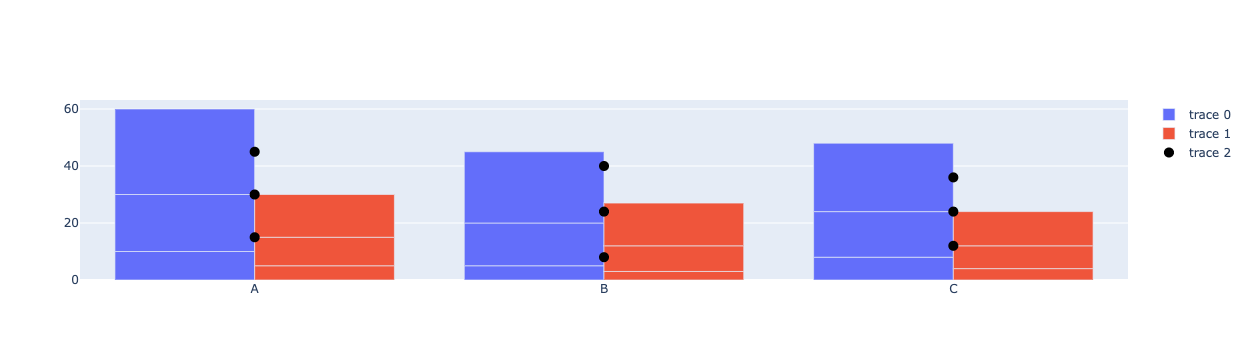

In [30]:
# Sample data
data = {
    'Category': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C'],
    'Value1': [10, 20, 30, 5, 15, 25, 8, 16, 24],
    'Value2': [5, 10, 15, 3, 9, 15, 4, 8, 12],
    'Additional Info': ['Info for A1', 'Info for A2', 'Info for A3', 'Info for B1', 'Info for B2', 'Info for B3', 'Info for C1', 'Info for C2', 'Info for C3']
}

df = pd.DataFrame(data)

fig = go.Figure()

# Create bar traces
bar1 = go.Bar(x=df['Category'], y=df['Value1'])
bar2 = go.Bar(x=df['Category'], y=df['Value2'])


fig3 = go.Figure(
    data=[
        go.Bar(
            name="Original",
            x=data["labels"],
            y=data["original"],
            offsetgroup=0,
        ),
        go.Bar(
            name="Model 1",
            x=data["labels"],
            y=data["model_1"],
            offsetgroup=1,
        ),
        go.Bar(
            name="Model 2",
            x=data["labels"],
            y=data["model_2"],
            offsetgroup=1,
            base=data["model_1"], 
        )
    ],
    layout=go.Layout(
        title="Issue Types - Original and Models",
        yaxis_title="Number of Issues"
    )
)
fig3.show()

In [ ]:

# Add scatter trace for markers (adjust marker size and color as desired)
markers = go.Scatter(
    x=df['Category'],
    y=[value1 + value2 for value1, value2 in zip(df['Value1'], df['Value2'])],
    mode='markers',
    marker=dict(size=10, color='black')
)

# Add traces to the figure and customize layout
fig.add_traces([bar1, bar2, markers])
# ... (layout customization)

fig.show()

In [32]:
data = pd.read_csv('../raw_data/data_for_ml.csv')

In [37]:
data.Attendance

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
469    1.0
470    1.0
471    1.0
472    1.0
473    1.0
Name: Attendance, Length: 474, dtype: float64